# Debugging Neural Networks

Debugging neural network models is a challenging task. It often requires a profound understanding of the techniques involved.

It is therefore important to have a well-defined strategy and follow some guidelines that will simplify model debugging. In general, it is crucial to implement the model step-by-step and do several checks along the way. The worse thing you can do is implement a complex system in one shot and hope everything is working.

Here are some additional suggestions:
1. Before implementing your model, carefully check your data. Make sure, for instance, that the inputs and the labels match. If you shuffle the data, make sure to shuffle inputs and labels in a consistent way (to avoid input-label mismatches).

2. Start with a simple model (e.g., a linear model). Remember: "*the more powerful the model the more sophisticated the bugs*". Make sure the code is running. Make sure the model is in train modality during training and eval modality during validation and test. The model will likely underfit, but you should see at least some small improvements in the training loss. If this does not happen:
- Carefully check the batches and ensure there is a matching between inputs and labels.
- Check the shapes on the tensors involved in your model and make sure they correspond to your expectations.
- Check the parameters of the network. If they remain constant, your gradient is likely zero. This can be caused by forgetting to call the backpropagation method or the step method of the optimizer.
- Make sure you applied the softmax on the right axis.
- Tweek a bit the hyperparameters of the model to see if there is at least one configuration that allows the loss to decrease a bit.
3. Implement your final model. Initialize it and make sure it runs. Fix possible dimensionality mismatch issues. Make sure all the shapes are the ones you expect.
4. Do an **overfitting test**. If your model cannot overfit on a tiny dataset (e.g., take 5-10 examples only) it likely contains a bug somewhere. To do an overfitting test, feed the model with a single batch composed of 5-10 examples. Run the model for several epochs with a pretty high learning rate. If everything is correct, you should see an almost perfect training loss and a very high validation loss. This means that the model can memorize data. Data memorization is not what we want in the end, but models that cannot overfit likely have a bug to fix.
5. Now, you can run your experiment. Check if the loss is decreasing. If you observe numerical instabilities (e.g., NaN) try to reduce the learning rate. If that does not help, consider using gradient clipping. You have to do your best to tune the hyperparameters of the model to maximize the validation performance.

Many other things can go wrong. You will progressively gain more and more experience and this will help you with debugging.

## **Debugging a PyTorch Code**
Let's now do a debugging exercise with PyTorch. Run the following code that attempts to implement a digit classification with an MLP using the MNIST dataset:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
torch.manual_seed(1)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hparams
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model init
model = Net(input_size, hidden_size, num_classes).to('cuda:0')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)


def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader:
    outputs = model(images)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()
    losses.append(l)
  return torch.tensor(losses).mean()


def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

100%|██████████| 9912422/9912422 [00:00<00:00, 116733241.36it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 54738225.86it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 43449716.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19223540.63it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

The code has several bugs. The first that appears is the following:

*Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_mm)*

This is a bug pretty easy to solve. It simply tells you that you have some tensors on the CPU and some tensors on the GPU.

The error happens in the forward method when we perform the first matrix multiplication between the input and the weight matrix. Now, if you look at the code you can understand what is the issue: we put our model on the GPU at the beginning but we forgot to put our data (both inputs and labels) on the GPU as well. To fix this, we can simply add `.to('cuda:0')` every time we read training and test data:


In [ ]:
class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hparams
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model init
model = Net(input_size, hidden_size, num_classes).to('cuda:0')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)


def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader:
    images= images.to('cuda:0')
    labels = labels.to('cuda:0')
    outputs = model(images)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()
    losses.append(l)
  return torch.tensor(losses).mean()


def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    images=images.to('cuda:0')
    labels = labels.to('cuda:0')
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x500)

Now, the first issue is fixed. Unfortunately, we have another one. This time is a dimensionality mismatch issue:

`RuntimeError: mat1 and mat2 shapes cannot be multiplied (3584x28 and 784x500)`

This again happens in the first linear transformation.  If you print the input shape of the image you realize that it is `torch.Size([128, 1, 28, 28])`. Our model,  instead, expects something like "torch.Size([128, 784]". We thus have to reshape the input tensors (both in the train and test functions) such that we match the expected dimension. This can be done with the view or reshape function:



side note: -1 means accept any number of samples
# images= images.view(-1,28*28).to('cuda:0')

Epoch: 1  train_loss=1.8744, test_loss=1.7517, test_err=51.70%
Epoch: 2  train_loss=1.8470, test_loss=1.8907, test_err=68.51%
Epoch: 3  train_loss=1.9283, test_loss=1.9695, test_err=62.48%
Epoch: 4  train_loss=1.8605, test_loss=2.4833, test_err=65.27%
Epoch: 5  train_loss=2.0084, test_loss=2.4623, test_err=70.83%
Epoch: 6  train_loss=2.0899, test_loss=3.3502, test_err=69.68%
Epoch: 7  train_loss=2.0565, test_loss=3.3269, test_err=71.25%
Epoch: 8  train_loss=2.0571, test_loss=4.2905, test_err=64.12%
Epoch: 9  train_loss=2.1651, test_loss=2.9426, test_err=73.69%
Epoch: 10  train_loss=2.0773, test_loss=3.2682, test_err=72.17%
Epoch: 11  train_loss=2.1859, test_loss=3.9328, test_err=75.14%
Epoch: 12  train_loss=2.3145, test_loss=4.3019, test_err=78.79%
Epoch: 13  train_loss=2.4045, test_loss=4.6338, test_err=78.30%
Epoch: 14  train_loss=2.3694, test_loss=5.6273, test_err=81.61%
Epoch: 15  train_loss=2.4166, test_loss=6.6169, test_err=78.78%
Epoch: 16  train_loss=2.4159, test_loss=6.3573, t

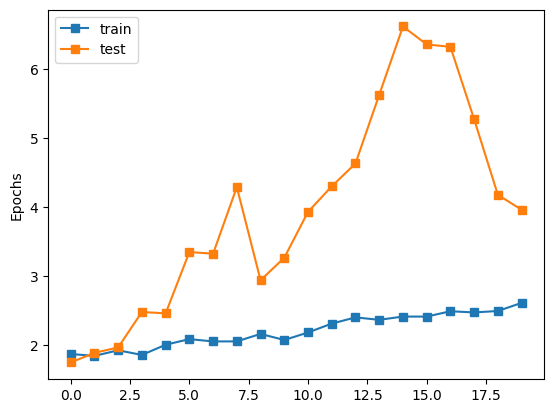

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
torch.manual_seed(1)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hparams
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model init
model = Net(input_size, hidden_size, num_classes).to('cuda:0')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)


def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader:
    images= images.view(-1,28*28).to('cuda:0')
    labels = labels.to('cuda:0')
    outputs = model(images)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()
    losses.append(l)
  return torch.tensor(losses).mean()


def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    images= images.view(-1,28*28).to('cuda:0')
    labels = labels.to('cuda:0')
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

Now the code runs, but the networks do not converge. This is the worse thing that can happen (and, unfortunately, it happens very often). There might be a bug somewhere. The first thing to check is the gradient backpropagation part.

*Do you notice something wrong?*

It looks like the method `.zero_grad()` is not called. This method is very important as it puts to zero the gradient buffers. It should be called before the backpropagation method. If not called, the gradient is accumulated at becomes unmeaningful soon. Here is the fixed version of the code:

Epoch: 1  train_loss=0.2039, test_loss=0.1061, test_err=3.46%
Epoch: 2  train_loss=0.0856, test_loss=0.0806, test_err=2.69%
Epoch: 3  train_loss=0.0591, test_loss=0.0926, test_err=2.69%
Epoch: 4  train_loss=0.0481, test_loss=0.0760, test_err=2.14%
Epoch: 5  train_loss=0.0382, test_loss=0.0929, test_err=2.28%
Epoch: 6  train_loss=0.0315, test_loss=0.1085, test_err=2.39%
Epoch: 7  train_loss=0.0345, test_loss=0.0877, test_err=2.07%
Epoch: 8  train_loss=0.0256, test_loss=0.0888, test_err=1.88%
Epoch: 9  train_loss=0.0232, test_loss=0.0899, test_err=2.07%
Epoch: 10  train_loss=0.0210, test_loss=0.1069, test_err=2.23%
Epoch: 11  train_loss=0.0255, test_loss=0.1177, test_err=2.14%
Epoch: 12  train_loss=0.0229, test_loss=0.1170, test_err=2.06%
Epoch: 13  train_loss=0.0260, test_loss=0.1482, test_err=2.34%
Epoch: 14  train_loss=0.0196, test_loss=0.1249, test_err=2.02%
Epoch: 15  train_loss=0.0160, test_loss=0.1438, test_err=2.02%
Epoch: 16  train_loss=0.0177, test_loss=0.1254, test_err=1.96%
E

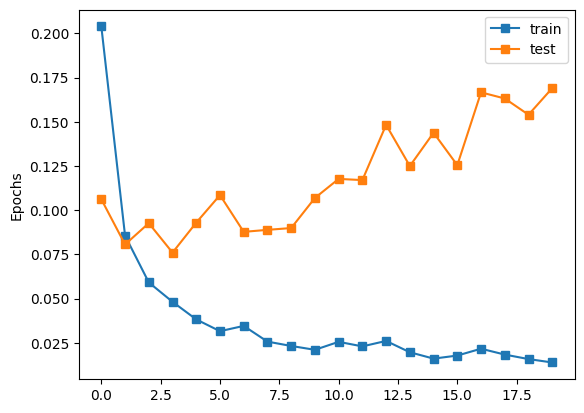

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
torch.manual_seed(1)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hparams
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model init
model = Net(input_size, hidden_size, num_classes).to('cuda:0')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)


def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader:
    images= images.view(-1,28*28).to('cuda:0')
    labels = labels.to('cuda:0')
    outputs = model(images)
    l = loss(outputs, labels)
    optimizer.zero_grad()
    l.backward()
    optimizer.step()
    losses.append(l)
  return torch.tensor(losses).mean()


def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    images= images.view(-1,28*28).to('cuda:0')
    labels = labels.to('cuda:0')
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l)

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

The code now runs and produces the expected results. However, there is still a little issue that should be fixed. When using PyTorch, we have to be very careful when accumulating PyTorch variables (e.g, loss_tot = loss_tot + l) or storing variables like we did (losses. append(l)). You always have to detach the variable (using `.detach()` or `.item()`). Otherwise, you keep them allocated and you might have an out-of-memory issue (especially when using big networks) because you backpropagate over them.


This is the final version of the code:

Epoch: 1  train_loss=0.2039, test_loss=0.1061, test_err=3.46%
Epoch: 2  train_loss=0.0856, test_loss=0.0806, test_err=2.69%
Epoch: 3  train_loss=0.0591, test_loss=0.0926, test_err=2.69%
Epoch: 4  train_loss=0.0481, test_loss=0.0760, test_err=2.14%
Epoch: 5  train_loss=0.0382, test_loss=0.0929, test_err=2.28%
Epoch: 6  train_loss=0.0315, test_loss=0.1085, test_err=2.39%
Epoch: 7  train_loss=0.0345, test_loss=0.0877, test_err=2.07%
Epoch: 8  train_loss=0.0256, test_loss=0.0888, test_err=1.88%
Epoch: 9  train_loss=0.0232, test_loss=0.0899, test_err=2.07%
Epoch: 10  train_loss=0.0210, test_loss=0.1069, test_err=2.23%
Epoch: 11  train_loss=0.0255, test_loss=0.1177, test_err=2.14%
Epoch: 12  train_loss=0.0229, test_loss=0.1170, test_err=2.06%
Epoch: 13  train_loss=0.0260, test_loss=0.1482, test_err=2.34%
Epoch: 14  train_loss=0.0196, test_loss=0.1249, test_err=2.02%
Epoch: 15  train_loss=0.0160, test_loss=0.1438, test_err=2.02%
Epoch: 16  train_loss=0.0177, test_loss=0.1254, test_err=1.96%
E

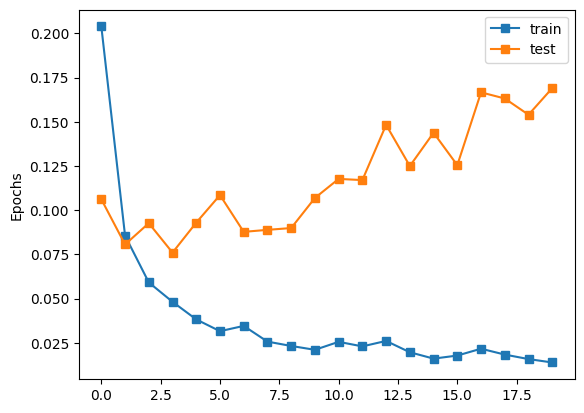

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
torch.manual_seed(1)

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

# Hparams
batch_size=128
epochs=20
lr=0.005
input_size = 784
hidden_size = 500
num_classes = 10

# Model init
model = Net(input_size, hidden_size, num_classes).to('cuda:0')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Datasets
train_data = datasets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)

test_data = datasets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
# Data loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)


def train(train_loader, model, loss, optimizer):
  losses=[]
  model.train()
  for images,labels in train_loader:
    images = images.view(-1,28*28).to('cuda:0')
    labels = labels.to('cuda:0')
    outputs = model(images)
    l = loss(outputs, labels)
    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    losses.append(l.item())
  return torch.tensor(losses).mean()


def test(test_loader, model, loss):
  losses=[]
  err=0
  model.eval()
  for images,labels in test_loader:
    images = images.view(-1,28*28).to('cuda:0')
    labels = labels.to('cuda:0')
    outputs = model(images)
    l = loss(outputs, labels)
    losses.append(l.item())

    predictions = torch.argmax(F.softmax(outputs, dim=1), dim=1)
    err = err + (predictions!=labels).sum().item()
  return torch.tensor(losses).mean(), err/len(test_loader.dataset)

# Training loop
train_losses=[]
test_losses=[]
for epoch in range(epochs):
  train_loss = train(train_loader, model, loss, optimizer)
  test_loss, test_err = test(test_loader, model, loss)
  train_losses.append(train_loss)
  test_losses.append(test_loss)

  print('Epoch: {}  train_loss={:.4f}, test_loss={:.4f}, test_err={:.2f}%'.format(epoch+1, train_loss, test_loss, test_err*100))

plt.plot(train_losses, '-s', label='train')
plt.plot(test_losses, '-s', label='test')
plt.ylabel('Loss')
plt.ylabel('Epochs')
plt.legend()
plt.show()

The best accuracy on the test set for this model should be around 98% (2% Error). As you can see, there is some overfitting when using such a small dataset.

There might be many other things that can go wrong when you implement your model. The experience will help you a lot with debugging.